In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [16]:
import torch
import numpy as np
import math
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset

import ipywidgets as widgets
import io
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
cudnn.bechmark = True
plt.ion()

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
path = f"/data/Ahsan/nomandata/Stroke_dataset"
path_last_trained = f"/data/Ahsan/nomandata/models/last_trained/bs_vit_atmap.pth.tar"
path_min_loss = f"/data/Ahsan/nomandata/models/min_loss/bs_vit_atmap.pth.tar"
path_max_acc = f"/data/Ahsan/nomandata/models/max_acc/bs_vit_atmap.pth.tar"

In [19]:
num_epochs = 150
batch_size = 64
lr_rate = 1e-4
load_model = True

In [20]:
def save_checkpoint(state, filename=path_last_trained):
  # print("===> Saving checkpoint")
  torch.save(state, filename)

In [21]:
def load_checkpoint(checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("===> Checkpoint Loaded.")
  return checkpoint['epoch'], checkpoint['loss'], checkpoint['accuracy']

In [22]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.RandomRotation([90, 180]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [23]:
def get_dataloader(dir, transform=transforms.ToTensor(), batch_size=64, shuffle=True, val_data=0.1, num_workers=1):
    dataset = datasets.ImageFolder(root=dir, transform=transform)
    n = len(dataset)
    val_data = int(n*val_data)
    train_ds, val_ds = random_split(dataset, [n-val_data, val_data])

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return train_ds, val_ds, train_dl, val_dl

In [24]:
classes = ['hemorhaege', 'ischemic', 'normal']

In [25]:
train_ds, val_ds, train_dl, val_dl = get_dataloader(path, transform=transform, batch_size=batch_size, shuffle=True,  val_data=0.3, num_workers=2)

In [26]:
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    # work with diff dim tensors, not just 2D ConvNets
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + \
        torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C //
                                  self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ 
    Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    """ 
    Vision Transformer 
    """

    def __init__(self, img_size=[224], patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        self.LSTM = nn.LSTM(input_size=embed_dim, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)

        # Classifier head
        self.head = nn.Linear(
            embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(
                math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(
            w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


class VitGenerator(object):
    def __init__(self, name_model, patch_size, device, evaluate=True, random=False, verbose=False):
        self.name_model = name_model
        self.patch_size = patch_size
        self.evaluate = evaluate
        self.device = device
        self.verbose = verbose
        self.model = self._getModel()
        self._initializeModel()
        if not random:
            self._loadPretrainedWeights()

    def _getModel(self):
        if self.verbose:
            print(
                f"[INFO] Initializing {self.name_model} with patch size of {self.patch_size}")
        if self.name_model == 'vit_tiny':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_small':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_base':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        else:
            raise f"No model found with {self.name_model}"

        return model

    def _initializeModel(self):
        if self.evaluate:
            for p in self.model.parameters():
                p.requires_grad = False

            self.model.eval()

        self.model.to(self.device)

    def _loadPretrainedWeights(self):
        if self.verbose:
            print("[INFO] Loading weights")
        url = None
        if self.name_model == 'vit_small' and self.patch_size == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

        elif self.name_model == 'vit_small' and self.patch_size == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"

        if url is None:
            print(
                f"Since no pretrained weights have been found with name {self.name_model} and patch size {self.patch_size}, random weights will be used")

        else:
            state_dict = torch.hub.load_state_dict_from_url(
                url="https://dl.fbaipublicfiles.com/dino/" + url)
            self.model.load_state_dict(state_dict, strict=True)

    def get_last_selfattention(self, img):
        return self.model.get_last_selfattention(img.to(self.device))

    def __call__(self, x):
        return self.model(x)

In [40]:
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.savefig(f'att_map.jpg', dpi=500)
    plt.show()

    img = transforms.Resize(224)(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='inferno')
    plt.imshow(np.mean(attention, 0), alpha=0.75)
    plt.title('Attention Map')
    plt.savefig(f'att_map.jpg', dpi=500)
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.savefig(f'att_map_head.jpg', dpi=500)
    plt.show()



class Loader(object):
    def __init__(self):
        self.uploader = widgets.FileUpload(accept='image/*', multiple=False)
        self._start()

    def _start(self):
        display(self.uploader)

    def getLastImage(self):
        try:
            for uploaded_filename in self.uploader.value:
                uploaded_filename = uploaded_filename
            img = Image.open(io.BytesIO(
                bytes(self.uploader.value[uploaded_filename]['content'])))

            return img
        except:
            return None

    def saveImage(self, path):
        with open(path, 'wb') as output_file:
            for uploaded_filename in self.uploader.value:
                content = self.uploader.value[uploaded_filename]['content']
                output_file.write(content)

In [28]:
model = VisionTransformer(patch_size=8, num_classes=3, embed_dim=384, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True).to(device)

In [29]:
# model = models.resnet18(pretrained=False).to(device)
# model.fc.out_features = 3

In [30]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (LSTM): LSTM(384, 512, num_

In [31]:
optimizer = optim.AdamW(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

In [32]:
import math 
if load_model:
  prev_epoch, prev_loss, prev_acc = load_checkpoint(torch.load(path_max_acc))
else:
  prev_epoch = 0
  prev_loss = math.inf
  prev_acc = -math.inf

===> Checkpoint Loaded.


In [33]:
import time

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
total_time = 0

for epoch in range(num_epochs-prev_epoch):
  start_time = time.time()
  losses = 0
  epoch = epoch+prev_epoch
  
  for idx, (data, targets) in enumerate(train_dl):
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    scores = model(data)
    loss = criterion(scores, targets)
    loss.backward()
    optimizer.step()

    losses += loss.item()

  new_loss = losses/len(train_dl)
  history["train_loss"].append(new_loss)
  
  total = 0
  correct = 0
  val_loss = 0
  with torch.no_grad():
    for images, labels in val_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      val_loss += criterion(outputs, labels).item()
      predicted = torch.argmax(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels).sum().item()
  
  new_acc = correct/total
  history["val_acc"].append(new_acc)
  history["val_loss"].append(val_loss/len(val_dl))

  total = 0
  correct = 0
  with torch.no_grad():
    for images, labels in train_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      predicted = torch.argmax(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels).sum().item()
  
  new_acc_train = correct/total
  history["train_acc"].append(new_acc_train)
  
  checkpoint = {'epoch': epoch, 'loss': new_loss, 'accuracy': new_acc, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
  save_checkpoint(checkpoint, path_last_trained)
  if new_loss < prev_loss: 
    save_checkpoint(checkpoint, path_min_loss)
    prev_loss = new_loss
  if new_acc > prev_acc:
    save_checkpoint(checkpoint, path_max_acc)
    prev_acc = new_acc
  
  end_time = time.time()
  total_time += end_time - start_time
  print("At Epoch [{}/{}] - {:.2f}s ====> Train Loss: {:.4f} || Val Loss: {:.4f} || Train Accuracy: {:.2f}% || Val Accuracy: {:.2f}%".format(epoch+1,num_epochs,end_time-start_time, history["train_loss"][-1], history["val_loss"][-1], history["train_acc"][-1]*100, history["val_acc"][-1]*100))
  

At Epoch [44/150] - 55.98s ====> Train Loss: 0.2924 || Val Loss: 0.2965 || Train Accuracy: 88.60% || Val Accuracy: 88.26%
At Epoch [45/150] - 55.17s ====> Train Loss: 0.2972 || Val Loss: 0.2936 || Train Accuracy: 89.05% || Val Accuracy: 88.57%
At Epoch [46/150] - 54.48s ====> Train Loss: 0.2925 || Val Loss: 0.3999 || Train Accuracy: 85.23% || Val Accuracy: 84.17%
At Epoch [47/150] - 54.58s ====> Train Loss: 0.3118 || Val Loss: 0.3221 || Train Accuracy: 87.84% || Val Accuracy: 87.21%
At Epoch [48/150] - 54.71s ====> Train Loss: 0.3135 || Val Loss: 0.2739 || Train Accuracy: 89.63% || Val Accuracy: 88.89%
At Epoch [49/150] - 54.67s ====> Train Loss: 0.2617 || Val Loss: 0.2963 || Train Accuracy: 88.69% || Val Accuracy: 87.21%
At Epoch [50/150] - 54.53s ====> Train Loss: 0.3181 || Val Loss: 0.2832 || Train Accuracy: 90.22% || Val Accuracy: 87.95%
At Epoch [51/150] - 54.61s ====> Train Loss: 0.2640 || Val Loss: 0.2687 || Train Accuracy: 90.35% || Val Accuracy: 88.68%
At Epoch [52/150] - 55.8

In [34]:
avg_time = total_time / len(history["train_acc"])
print("Total training time: {:.2f}s Average training time: {:.2f}s".format(total_time, avg_time))

Total training time: 5827.87s Average training time: 54.47s


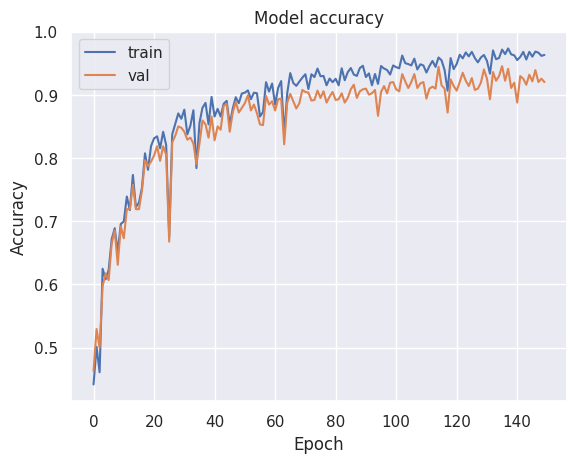

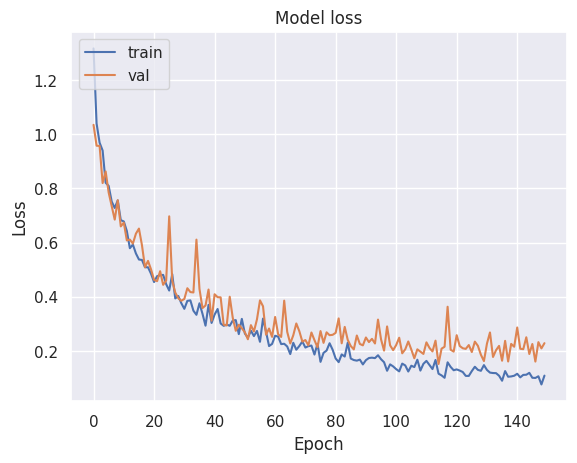

In [64]:
import seaborn as sns
sns.set_theme()
epoch = list(range(len(history["train_acc"])))
# summarize history for accuracy
plt.plot(epoch, history["train_acc"])
plt.plot(epoch, history["val_acc"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'accuracy.jpg', dpi=500)
plt.show()

# summarize history for loss
plt.plot(epoch, history["train_loss"])
plt.plot(epoch, history["val_loss"])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'loss.jpg', dpi=500)
plt.show()


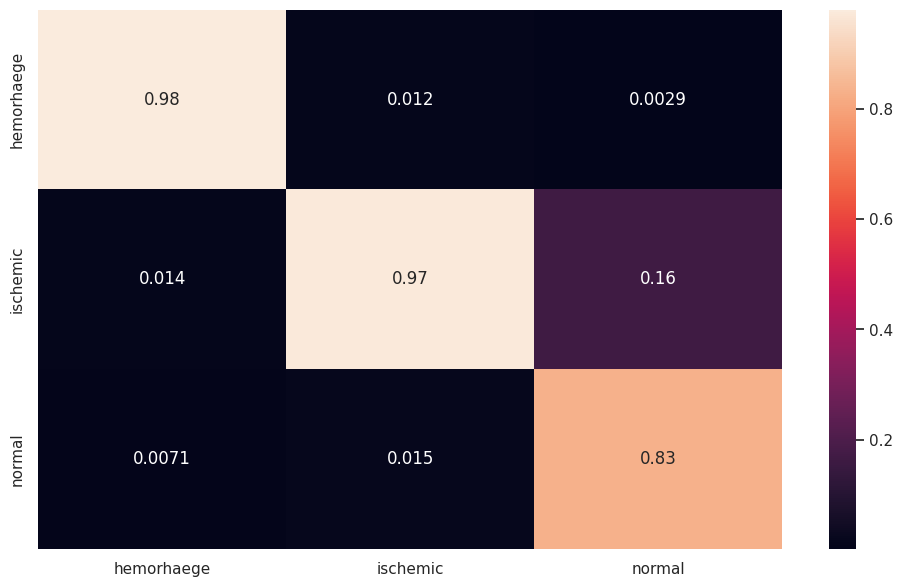

In [65]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) # Feed Network

        outputs = (torch.argmax(outputs.data, 1)).data.cpu().numpy()
        y_pred.extend(outputs) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix = cf_matrix/np.sum(cf_matrix, axis=0)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig(f'confusionMatrix.jpg', dpi=500)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       282
           1       0.97      0.84      0.90       376
           2       0.83      0.98      0.90       296

    accuracy                           0.92       954
   macro avg       0.93      0.93      0.93       954
weighted avg       0.93      0.92      0.92       954



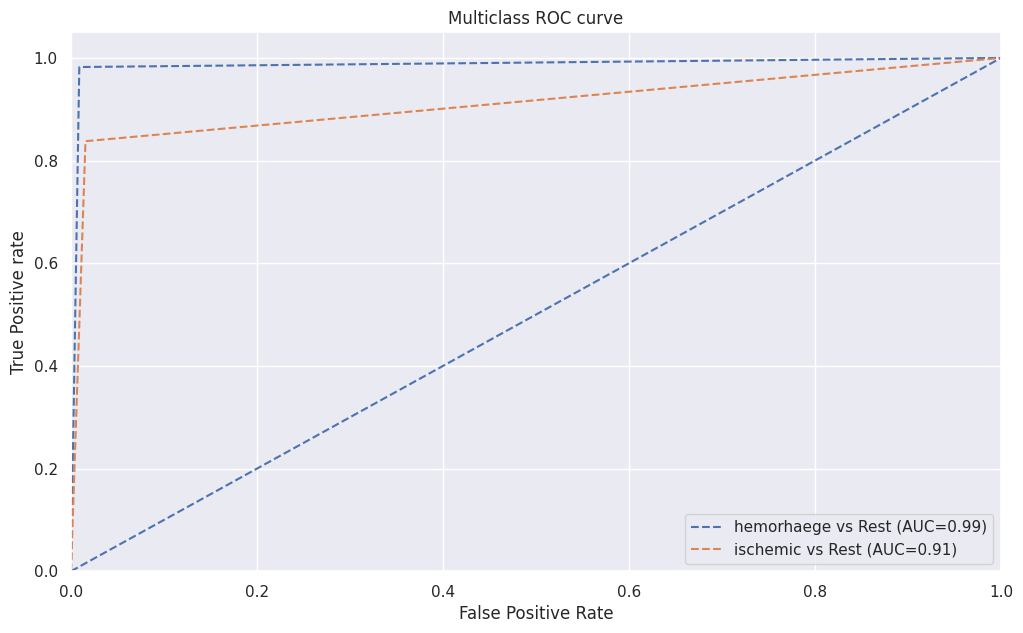

In [67]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = label_binarize(y_true, classes=[0,1,2])
y_pred = label_binarize(y_pred, classes=[0,1,2])
y_true.shape, y_pred.shape

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = len(classes)-1
sns.set_theme()
plt.figure(figsize = (12,7))

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.savefig(f'roc_curve_smids.jpg', dpi=500)
plt.show()

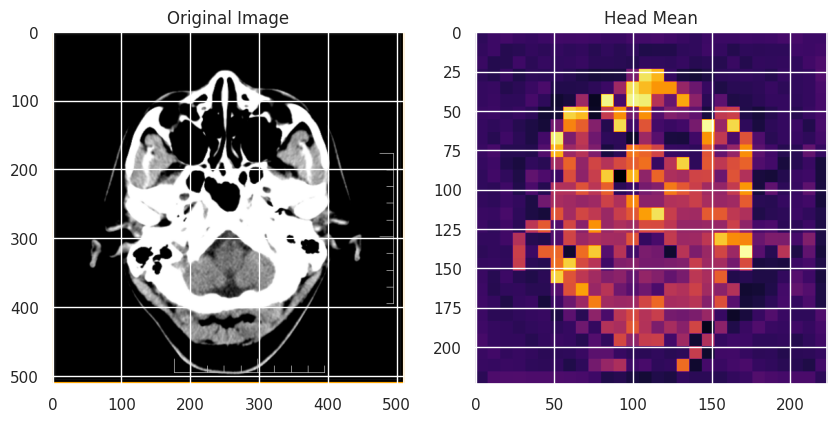

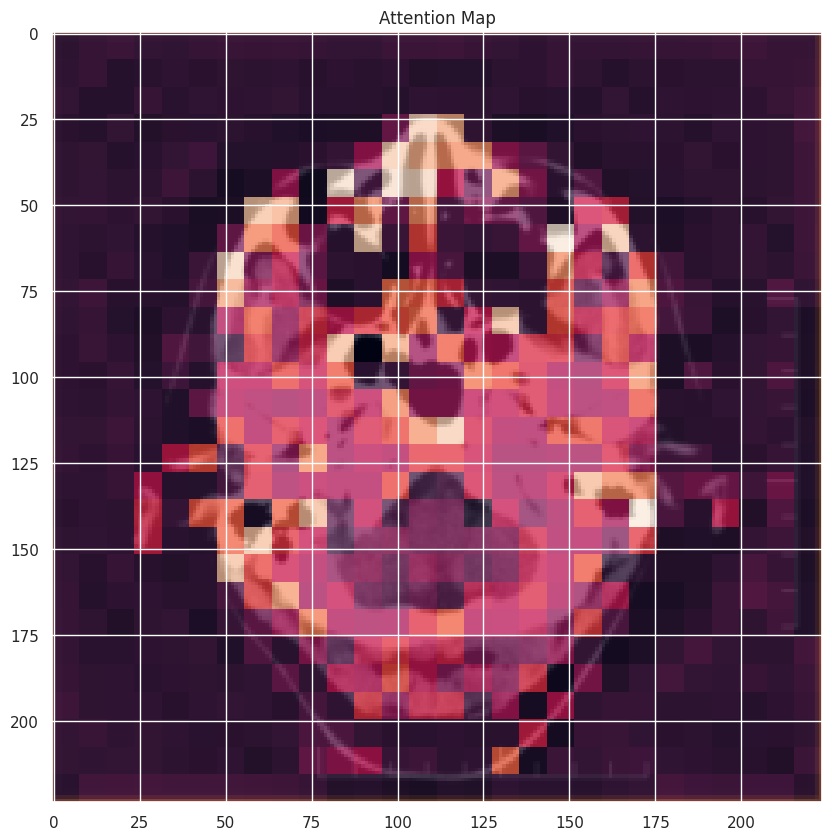

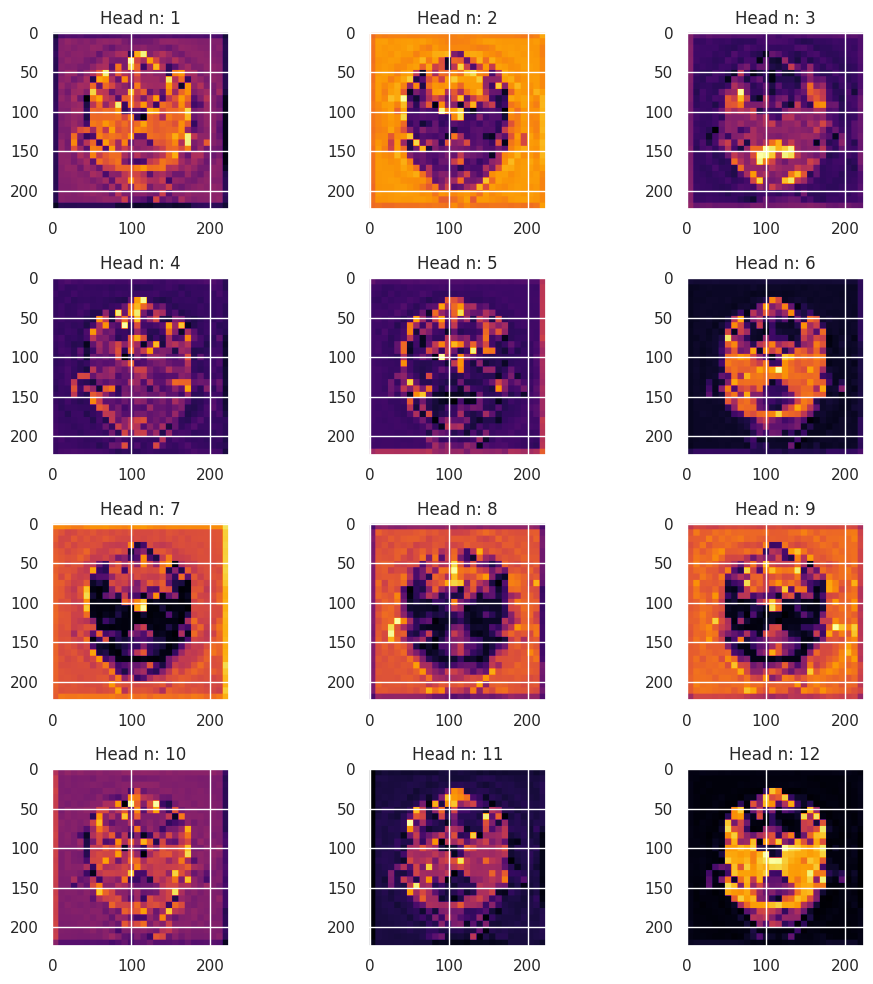

In [41]:


name_model = 'vit_small'
patch_size = 8

# model = VitGenerator(name_model, patch_size, 
#                      device, evaluate=True, random=False, verbose=True)



# Visualizing Dog Image
path = '/data/Ahsan/nomandata/Stroke_dataset/Normal/1.jpg'
img = Image.open(path)
img = img.convert('RGB') 
factor_reduce = 2
# img_size = tuple(np.array(img.size[::-1]) // factor_reduce) 
img_size = 224
visualize_predict(model, img, img_size, patch_size, device)